In [1]:
# Install libraries
!pip install cv2
!pip install glob
!pip install colabcode
!pip install python-multipart
!pip install flask-ngrok

ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2
ERROR: Could not find a version that satisfies the requirement glob (from versions: none)
ERROR: No matching distribution found for glob


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import re
import glob
from sklearn.model_selection import train_test_split
import seaborn as sns
import cv2
import random
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import StratifiedKFold
from keras.models import model_from_json
from colabcode import ColabCode
from flask import Flask, request
from tensorflow.keras.applications.vgg16 import VGG16

In [3]:
# Import data
trainData = glob.glob('/content/drive/MyDrive/Dogs and cats/train/*.jpg')
testData = glob.glob('/content/drive/MyDrive/Dogs and cats/test1/*.jpg')

In [4]:
# Data visualization

In [5]:
print(f'Total number of training data is {len(trainData)}.')
print(f'Total number of test data is {len(testData)}.')

Total number of training data is 25000.
Total number of test data is 12500.


In [6]:
dogs, cats = 0,0
for x in trainData:
    temp = x.split('/')[-1]
    temp = temp.split('.')[0]
    if temp == 'cat':
        cats += 1
    else:
        dogs += 1

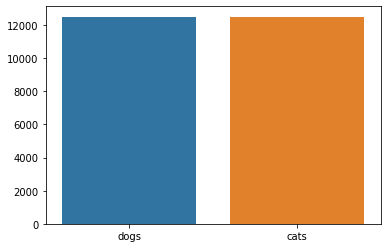

In [7]:
# There is no class imbalancee, because both class data are equally distributed.
sns.barplot(x = ['dogs','cats'], y=[dogs,cats])
plt.show()

In [8]:
# From above figure we can see both class are equally divided and there is no case of imbalanced classification.

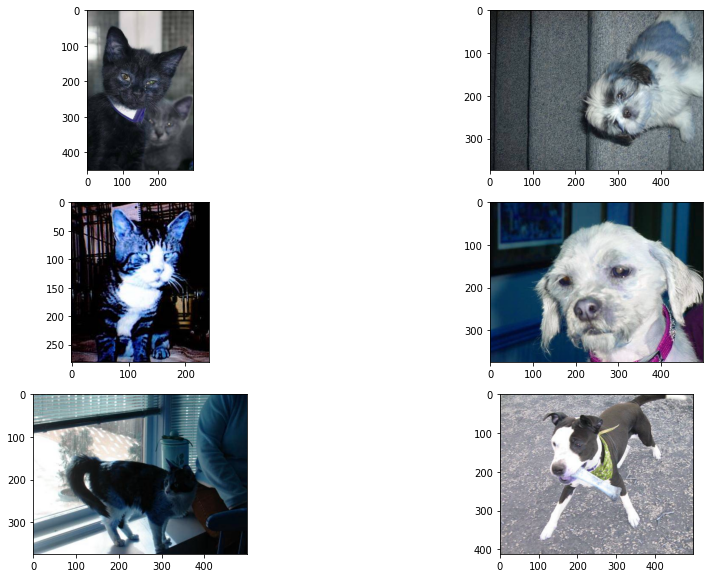

In [9]:
# Let's plot some of the images as examples.
img1 = cv2.imread('/content/drive/MyDrive/Dogs and cats/train/cat.3341.jpg')
img2 = cv2.imread('/content/drive/MyDrive/Dogs and cats/train/dog.2789.jpg')
img3 = cv2.imread('/content/drive/MyDrive/Dogs and cats/train/cat.10834.jpg')
img4 = cv2.imread('/content/drive/MyDrive/Dogs and cats/train/dog.9715.jpg')
img5 = cv2.imread('/content/drive/MyDrive/Dogs and cats/train/cat.4771.jpg')
img6 = cv2.imread('/content/drive/MyDrive/Dogs and cats/train/dog.10262.jpg')
f, axis = plt.subplots(nrows=3, ncols=2, figsize=(15,10))
axis[0,0].imshow(img1)
axis[0,1].imshow(img2)
axis[1,0].imshow(img3)
axis[1,1].imshow(img4)
axis[2,0].imshow(img5)
axis[2,1].imshow(img6)
plt.show()

In [10]:
# As we compared earlier data is properly classified and in that case we do not need to make any big changes 
# like data augmentation and adding noise or something. We try to train with basic network if doesn't work we
# will add some noise to it.

In [11]:
def decodeImageLabels(filePath):
#   Reading files from file path  
    bits = tf.io.read_file(filePath)
#   Converts image to numpy array and also divides it with 255 so all values fall between 0 to 1  
#   main reason for doing this is our model computation would be very lower.
    bits = tf.image.decode_jpeg(bits, channels=3) / 255
#   resizing images to 64x64
    image = tf.image.resize(bits, size=[64,64])
#   Decoding labels  
    temp = tf.strings.split(filePath, sep='/')[-1]
    temp = tf.strings.split(temp, sep='.')[0]
#   1 for dog, 0 for cat
    label = 1
    if temp =='cat':
        label = 0
    label = tf.reshape(label, [])
    return image, label

In [12]:
# This will make sure we are utilizing all of our CPU cores as we know that data pre-processing runs on CPU
# model computation runs on GPU.
AUTOTUNE = tf.data.experimental.AUTOTUNE
ignore_order = tf.data.Options()
# This will make sure to not follow order while data comes it will take data as data streams in
ignore_order.experimental_deterministic = False

In [13]:
# Random shuffle files
random.shuffle(trainData)
# Split files
trainTestData, testTrainData = train_test_split(trainData, test_size=0.1)
trainValData, valTrainData = train_test_split(trainTestData, test_size=0.1)

In [14]:
print(f'Training dataset size is {len(trainValData)}.\nValidation dataset size is {len(valTrainData)}.\nTest dataset size is {len(testTrainData)}.')

Training dataset size is 20250.
Validation dataset size is 2250.
Test dataset size is 2500.


In [15]:
# Convert image paths to tensors
trainImages = tf.data.Dataset.from_tensor_slices(trainValData)
valImages = tf.data.Dataset.from_tensor_slices(valTrainData)

In [16]:
trainImages = trainImages.with_options(ignore_order)
valImages = valImages.with_options(ignore_order)

In [17]:
# AUTOTUNE will make sure we are using all the cores
trainImages = trainImages.map(decodeImageLabels, num_parallel_calls=AUTOTUNE)
# Repeting data so we can use multiple times on epoches.
trainImages = trainImages.repeat()
# Creating each batch with 512 images.
trainImages = trainImages.batch(512)
valImages = valImages.map(decodeImageLabels, num_parallel_calls=AUTOTUNE)
valImages = valImages.batch(512)

In [18]:
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, verbose = 1, mode = 'min', restore_best_weights=True)

Model lines:


1.   Baseline custom models, custom model
2.   VGG16 model
3.   Resnet50 model



In [23]:
with tf.device('/device:GPU:0'):
  model = keras.models.Sequential([
    keras.layers.Conv2D(filters=8, kernel_size=2, activation='relu', padding='same', input_shape=[64,64,3]),
    keras.layers.Conv2D(filters=16, kernel_size=2, activation='relu', padding='same'),
    keras.layers.Conv2D(filters=32, kernel_size=2, activation='relu', padding='same'),
    keras.layers.MaxPool2D(2),
    keras.layers.Conv2D(filters=64, kernel_size=2, activation='relu', padding='same'),
    keras.layers.MaxPool2D(2),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(filters=128, kernel_size=2, activation='relu', padding='same'),
    keras.layers.MaxPool2D(3),
    # To stop overfitting at some place we place dropout points.
    keras.layers.Dropout(0.7),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
  ])
  optimizer = keras.optimizers.Adam()
  model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(name='precision')])
  history = model.fit(trainImages, verbose=1, steps_per_epoch=50, epochs=70, validation_data=valImages, callbacks=[early])

Epoch 1/70
50/50 [==============================] - 1150s 23s/step - loss: 0.6969 - accuracy: 0.4978 - auc: 0.4990 - precision: 0.4929 - val_loss: 0.6917 - val_accuracy: 0.6236 - val_auc: 0.6166 - val_precision: 0.6268
Epoch 2/70
50/50 [==============================] - 34s 674ms/step - loss: 0.6886 - accuracy: 0.5435 - auc: 0.5598 - precision: 0.5372 - val_loss: 0.6722 - val_accuracy: 0.6293 - val_auc: 0.7008 - val_precision: 0.7119
Epoch 3/70
50/50 [==============================] - 34s 676ms/step - loss: 0.6606 - accuracy: 0.6039 - auc: 0.6448 - precision: 0.6373 - val_loss: 0.6130 - val_accuracy: 0.6876 - val_auc: 0.7717 - val_precision: 0.7755
Epoch 4/70
50/50 [==============================] - 34s 674ms/step - loss: 0.6215 - accuracy: 0.6495 - auc: 0.7169 - precision: 0.6903 - val_loss: 0.5729 - val_accuracy: 0.7089 - val_auc: 0.8034 - val_precision: 0.7836
Epoch 5/70
50/50 [==============================] - 34s 677ms/step - loss: 0.5959 - accuracy: 0.6787 - auc: 0.7495 - precisi

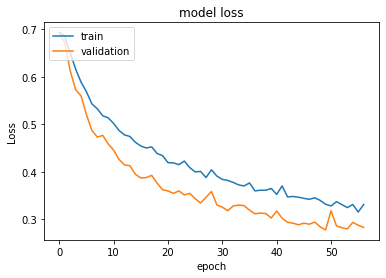

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

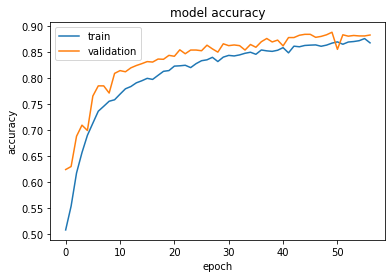

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [24]:
base_model = VGG16(input_shape = (64, 64, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')
x = keras.layers.Flatten()(base_model.output)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.models.Model(base_model.input, x)
model.compile(optimizer = tf.keras.optimizers.SGD(), loss = 'binary_crossentropy',metrics = ['acc', keras.metrics.AUC(name='AUC')])

58892288/58889256 [==============================] - 1s 0us/step


In [26]:
# 40 epochs are enough
history = model.fit(trainImages, verbose=1, steps_per_epoch=50, epochs=40, validation_data=valImages)

Epoch 1/40
50/50 [==============================] - 3146s 64s/step - loss: 0.6305 - acc: 0.6593 - AUC: 0.7141 - val_loss: 0.4535 - val_acc: 0.7871 - val_AUC: 0.9246
Epoch 2/40
50/50 [==============================] - 44s 887ms/step - loss: 0.4632 - acc: 0.7829 - AUC: 0.8579 - val_loss: 0.3939 - val_acc: 0.8133 - val_AUC: 0.9343
Epoch 3/40
50/50 [==============================] - 45s 899ms/step - loss: 0.3758 - acc: 0.8334 - AUC: 0.9118 - val_loss: 0.3828 - val_acc: 0.8164 - val_AUC: 0.9436
Epoch 4/40
50/50 [==============================] - 44s 888ms/step - loss: 0.3153 - acc: 0.8653 - AUC: 0.9388 - val_loss: 0.2882 - val_acc: 0.8787 - val_AUC: 0.9551
Epoch 5/40
50/50 [==============================] - 44s 885ms/step - loss: 0.2868 - acc: 0.8791 - AUC: 0.9493 - val_loss: 0.2673 - val_acc: 0.8840 - val_AUC: 0.9583
Epoch 6/40
50/50 [==============================] - 44s 884ms/step - loss: 0.2620 - acc: 0.8891 - AUC: 0.9581 - val_loss: 0.2490 - val_acc: 0.8929 - val_AUC: 0.9635
Epoch 7/40

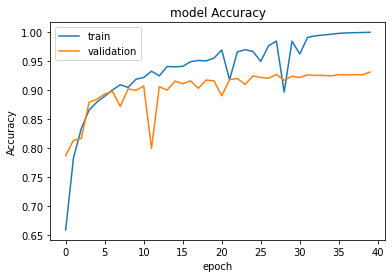

In [29]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [116]:
# Saving model to json
model_json = model.to_json()
# Writing model to JSON
with open('model.json', 'w') as json_file:
  json_file.write(model_json)
# Write model weights h5
model.save_weights('model.h5')
print('Model saved to disk.')

In [19]:
# Load JSON file
newModel = open('/content/model.json', 'r')
# After loading JSON model and reading JSON model
loadNewModel = newModel.read()
newModel.close()
# Load model from JSON
loadedModel = model_from_json(loadNewModel)
# Load weights to our model
loadedModel.load_weights('/content/model.h5')

In [20]:
loadedModel.compile(optimizer = tf.keras.optimizers.SGD(), loss = 'binary_crossentropy',metrics = ['acc', keras.metrics.AUC(name='AUC')])

In [21]:
baseLineFold = StratifiedKFold(n_splits=5)
trainLabel = []
for x in trainValData:
    temp = x.split('/')[-1]
    temp = temp.split('.')[0]
    if temp == 'cat':
        trainLabel.append(0)
    if temp == 'dog':
        trainLabel.append(1)

Epoch 1/40
100/100 [==============================] - 94s 928ms/step - loss: 7.6018e-05 - accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - val_loss: 9.4383e-05 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_precision: 1.0000
Epoch 2/40
100/100 [==============================] - 93s 930ms/step - loss: 6.2615e-05 - accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - val_loss: 9.1437e-05 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_precision: 1.0000
Epoch 3/40
100/100 [==============================] - 93s 928ms/step - loss: 6.4901e-05 - accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - val_loss: 9.0896e-05 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_precision: 1.0000
Epoch 4/40
100/100 [==============================] - 93s 927ms/step - loss: 6.6066e-05 - accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - val_loss: 9.3695e-05 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_precision: 1.0000
Epoch 5/40
100/100 [==============================] - 93s 932ms/step - loss: 6.0113e

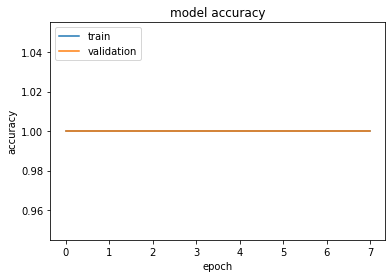

Epoch 1/40
100/100 [==============================] - 95s 940ms/step - loss: 1.2948e-04 - accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - val_loss: 5.0763e-05 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_precision: 1.0000
Epoch 2/40
100/100 [==============================] - 94s 936ms/step - loss: 7.9187e-05 - accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - val_loss: 4.9608e-05 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_precision: 1.0000
Epoch 3/40
100/100 [==============================] - 93s 934ms/step - loss: 7.2338e-05 - accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - val_loss: 4.7952e-05 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_precision: 1.0000
Epoch 4/40
100/100 [==============================] - 94s 939ms/step - loss: 6.7702e-05 - accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - val_loss: 4.7282e-05 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_precision: 1.0000
Epoch 5/40
100/100 [==============================] - 94s 936ms/step - loss: 6.2864e

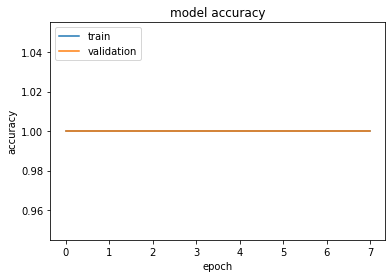

Epoch 1/40
100/100 [==============================] - 94s 931ms/step - loss: 9.2852e-05 - accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - val_loss: 2.5513e-05 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_precision: 1.0000
Epoch 2/40
100/100 [==============================] - 93s 933ms/step - loss: 7.8726e-05 - accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - val_loss: 2.6009e-05 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_precision: 1.0000
Epoch 3/40
100/100 [==============================] - 94s 937ms/step - loss: 9.5798e-05 - accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - val_loss: 2.5833e-05 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_precision: 1.0000
Epoch 4/40
100/100 [==============================] - 93s 934ms/step - loss: 7.8092e-05 - accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - val_loss: 2.5256e-05 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_precision: 1.0000
Epoch 5/40
100/100 [==============================] - 93s 933ms/step - loss: 6.5733e

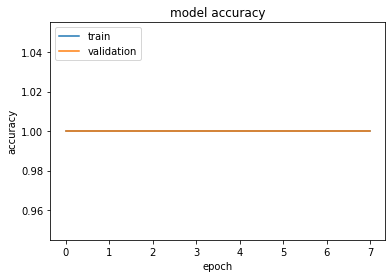

Epoch 1/40
100/100 [==============================] - 95s 934ms/step - loss: 9.5265e-05 - accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - val_loss: 2.4763e-05 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_precision: 1.0000
Epoch 2/40
100/100 [==============================] - 93s 927ms/step - loss: 7.3835e-05 - accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - val_loss: 2.4925e-05 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_precision: 1.0000
Epoch 3/40
100/100 [==============================] - 93s 926ms/step - loss: 7.6307e-05 - accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - val_loss: 2.3721e-05 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_precision: 1.0000
Epoch 4/40
100/100 [==============================] - 92s 925ms/step - loss: 6.2812e-05 - accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - val_loss: 2.4339e-05 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_precision: 1.0000
Epoch 5/40
100/100 [==============================] - 93s 930ms/step - loss: 6.5042e

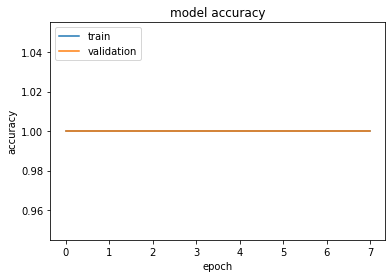

Epoch 1/40
100/100 [==============================] - 94s 933ms/step - loss: 8.7273e-05 - accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - val_loss: 1.8950e-05 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_precision: 1.0000
Epoch 2/40
100/100 [==============================] - 93s 928ms/step - loss: 6.9622e-05 - accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - val_loss: 1.9823e-05 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_precision: 1.0000
Epoch 3/40
100/100 [==============================] - 93s 933ms/step - loss: 5.9731e-05 - accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - val_loss: 1.8672e-05 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_precision: 1.0000
Epoch 4/40
100/100 [==============================] - 93s 927ms/step - loss: 6.8993e-05 - accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - val_loss: 1.9901e-05 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_precision: 1.0000
Epoch 5/40
100/100 [==============================] - 93s 927ms/step - loss: 6.6812e

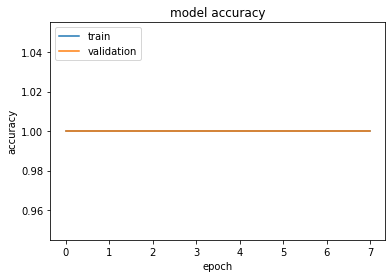

In [36]:
# Cross validation with 5 fold gives 100% accuracy with all folds.
for train_index, test_index in baseLineFold.split(trainValData, trainLabel):
    trainFoldFiles = []
    testFoldFiles = []
    for x in train_index:
        trainFoldFiles.append(trainValData[x])
    for x in test_index:
        testFoldFiles.append(trainValData[x])
    # Convert image paths to tensors
    trainImages = tf.data.Dataset.from_tensor_slices(trainFoldFiles)
    valImages = tf.data.Dataset.from_tensor_slices(testFoldFiles)
    trainImages = trainImages.with_options(ignore_order)
    valImages = valImages.with_options(ignore_order)
    # AUTOTUNE will make sure we are using all the cores
    trainImages = trainImages.map(decodeImageLabels, num_parallel_calls=AUTOTUNE)
    # Repeting data so we can use multiple times on epoches.
    trainImages = trainImages.repeat()
    # Creating each batch with 512 images.
    trainImages = trainImages.batch(512)
    valImages = valImages.map(decodeImageLabels, num_parallel_calls=AUTOTUNE)
    valImages = valImages.batch(512)
    # model = baseLine()
    model.compile(optimizer=keras.optimizers.SGD(), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(name='precision')])
    early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7, verbose = 1, mode = 'max', restore_best_weights=True)
    history = model.fit(trainImages, verbose=1, steps_per_epoch=100, epochs=40, validation_data=valImages, callbacks=[early])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [37]:
testImg = tf.data.Dataset.from_tensor_slices(testTrainData)
testImg = testImg.with_options(ignore_order)
testImg = testImg.map(decodeImageLabels, num_parallel_calls=AUTOTUNE)
testImg = testImg.batch(512)
testImg = testImg.prefetch(AUTOTUNE)

In [40]:
testTrainLabels = []
for x in testTrainData:
  temp = x.split('/')[-1]
  temp = temp.split('.')[0]
  if temp == 'cat':
    testTrainLabels.append(0)
  else:
    testTrainLabels.append(1)

In [42]:
model.evaluate(testImg)

5/5 [==============================] - 4s 832ms/step - loss: 0.6097 - accuracy: 0.9336 - auc: 0.9551 - precision: 0.9347


[0.6096697449684143, 0.9336000084877014, 0.9550907015800476, 0.934661328792572]

In [98]:
def testImage(filePath):
#   Reading files from file path  
    bits = tf.io.read_file(filePath)
#   Converts image to numpy array and also divides it with 255 so all values fall between 0 to 1  
#   main reason for doing this is our model computation would be very lower.
    bits = tf.image.decode_jpeg(bits, channels=3) / 255
#   resizing images to 64x64
    image = tf.image.resize(bits, size=[64,64])
    return image

In [115]:
# This is the way to find prediction for single file
# model.predict(np.array(['File name']))

In [22]:
def testImageAPI(bits):
#   Reading files from file path  
#   Converts image to numpy array and also divides it with 255 so all values fall between 0 to 1  
#   main reason for doing this is our model computation would be very lower.
    bits = tf.image.decode_jpeg(bits, channels=3) / 255
#   resizing images to 64x64
    image = tf.image.resize(bits, size=[64,64])
    return image

In [25]:
# Flask backend API for deeploying ML model
from flask_ngrok import run_with_ngrok
app = Flask(__name__)
run_with_ngrok(app)
@app.route('/', methods=['GET'])
def home():
  return 'Hello World'
@app.route('/predict', methods=['POST'])
def predict():
  if request.method == 'POST':
    image_file = request.files['image']
    if image_file:
      req = image_file.read()
      x = loadedModel.predict(np.array([testImageAPI(req)]))[0][0]
      if x >= 0.5:
        return 'Dog'
      elif x < 0.5:
        return 'Cat'
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://86a0beda2c57.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [20/Feb/2021 09:06:03] "POST /predict HTTP/1.1" 200 -
